In [14]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Deconv2D, Cropping2D, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute,  LeakyReLU, BatchNormalization, AveragePooling2D
from keras.layers import Dense, Flatten, Activation, Dropout, Embedding, Add,Concatenate,MaxPool2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [15]:
import os
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [16]:
from scipy.io import loadmat
np.random.seed(42)


In [17]:

im_width = 150
im_height = 150
border = 5
path_train = '/Users/olgalavricenko/Documents/DuckData/train/'
path_test = '/Users/olgalavricenko/Documents/DuckData/val'
# Каталог с данными для обучения
train_dir = '/Users/olgalavricenko/Documents/DuckData/train'
# Каталог с данными для проверки
val_dir = '/Users/olgalavricenko/Documents/DuckData/val'
# Каталог с данными для тестирования
test_dir = '/Users/olgalavricenko/Documents/DuckData/val'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 69972
# Количество изображений для проверки
nb_validation_samples = 1372
# Количество изображений для тестирования
nb_test_samples = 1372


In [18]:
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = load_img(path + '/image/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (150, 150, 1), mode='constant', preserve_range=True)

        X[n, ..., 0] = x_img.squeeze() / 256.0
    
        mask = img_to_array(load_img(path + '/segm/' + id_, grayscale=True))
        mask = resize(mask, (150, 150, 1), mode='constant', preserve_range=True)
        y[n] = mask / 256.0
    if train:
        return X, y
    else:
        return X
X, y = get_data(path_train, train=True)


Getting and resizing images ... 


HBox(children=(IntProgress(value=0, max=3001), HTML(value='')))

/Users/olgalavricenko/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
 #не запускать
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

    x_img = []
    y_img = []
    img_path = path+'image';

    for filename in os.listdir(img_path):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(img_path, filename))
            img=resize(img, (150,150,1), mode='constant', preserve_range=True)
            if img is not None:
                x_img.append(img)
    #print(x_img)
  #  x_img = resize(x_img, (150, 150, 1), mode='constant', preserve_range=True)

    img_path2 = path+'segm';
    for filename in os.listdir(img_path2):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(img_path2, filename))
            img=resize(img, (150,150,1), mode='constant', preserve_range=True)
            if img is not None:
                y_img.append(img)
    #print(y_img)

   
    if train:
        return X, y
    else:
        return X
X, y = get_data(path_train, train=True)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

In [20]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

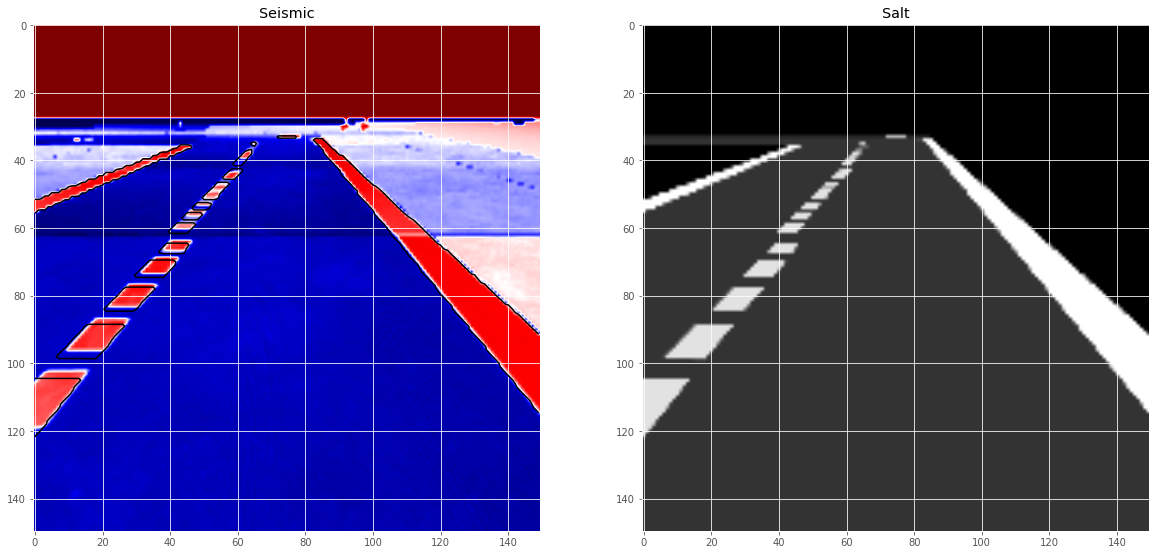

In [21]:
import random

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
    ax[1].set_title('Salt');

In [22]:
def ResConv(kol_kanal , inp ):
    a = Conv2D(kol_kanal,(1,1) ,padding="same", activation="relu" )(inp)
    b = Conv2D(kol_kanal, (3, 3), padding="same", activation="relu")(a)
    c = Conv2D(4*kol_kanal, (1, 1), padding="same", activation=None)(b)
    d = Concatenate()([c,inp])
    e=Activation('relu')(d)
    return e

def ResDeConv( inp ):
    a = UpSampling2D((1,1)  )(inp)
    b = UpSampling2D( (3, 3))(a)
    c = UpSampling2D( (1, 1) )(b)
    
    d=Activation('relu')(c)
    return d

input_shape=(150,150,1)
inp0=Input(input_shape)

model = Sequential()


a = MaxPool2D((3,3),2)(inp0)
skip1 = ResConv(32,a)
a = MaxPool2D((3,3),2)(skip1)
a = ResConv(32,a)
a = MaxPool2D((2,2),2)(a)
a = ResConv(32,a)
a=MaxPool2D((2,2))(a)


a=ResDeConv(a)
a=Conv2D(256,(1,1) ,padding="same", activation="relu" )(a)
a=ResDeConv(a)

a=Conv2D(131,(1,1) ,padding="same", activation="relu" )(a)
a=Cropping2D((3,3))(a)
a=UpSampling2D((2,2))(a)
a=Conv2D(1,(1,1),padding="same", activation="relu")(a)


model = Model(inp0, a)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 74, 74, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 74, 74, 32)   64          max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 74, 74, 32)   9248        conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

In [23]:
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [94]:
model_json = model.to_json()
json_file = open("mnist_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("model1.h5")

In [102]:
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'activation' is not defined